In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; 
device = 'cuda'
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
fdataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(fdataset, batch_size=64, shuffle=True, num_workers=4)

images, labels = next(iter(dataloader))
print(f"{images.shape=} {labels.shape=}")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape=torch.Size([64, 1, 28, 28]) labels.shape=torch.Size([64])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

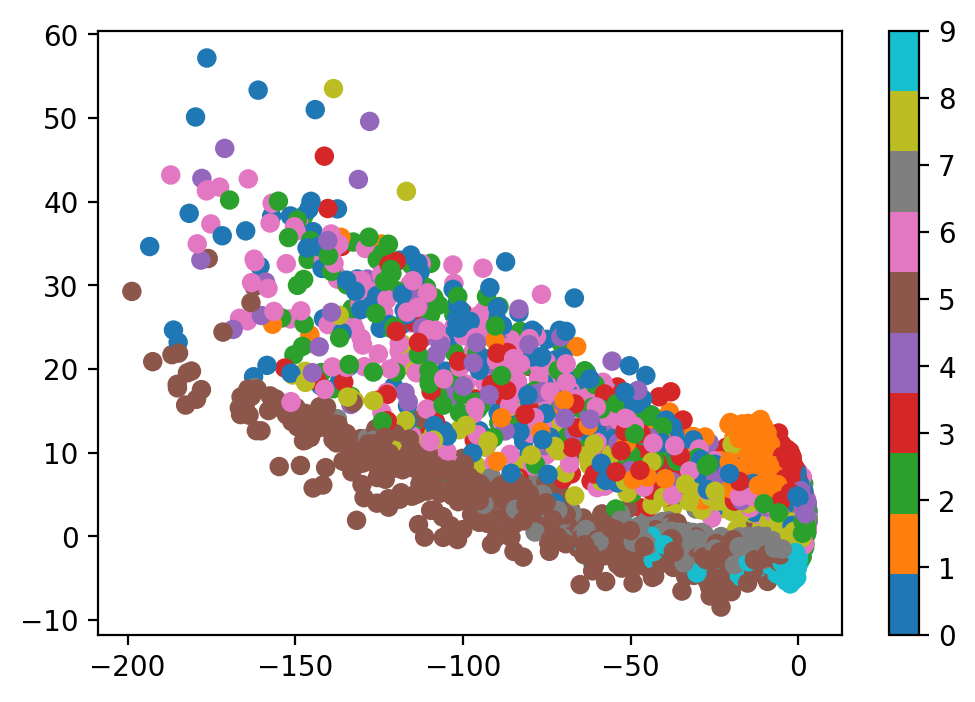

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
data = dataloader

autoencoder = train(autoencoder, data)

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plt.rcParams['figure.dpi'] = 200
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    r0 *= 10
    r1 *= 10
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            y/=10
            x/=10
            # print(x,y)
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])


class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
plot_reconstructed(autoencoder)

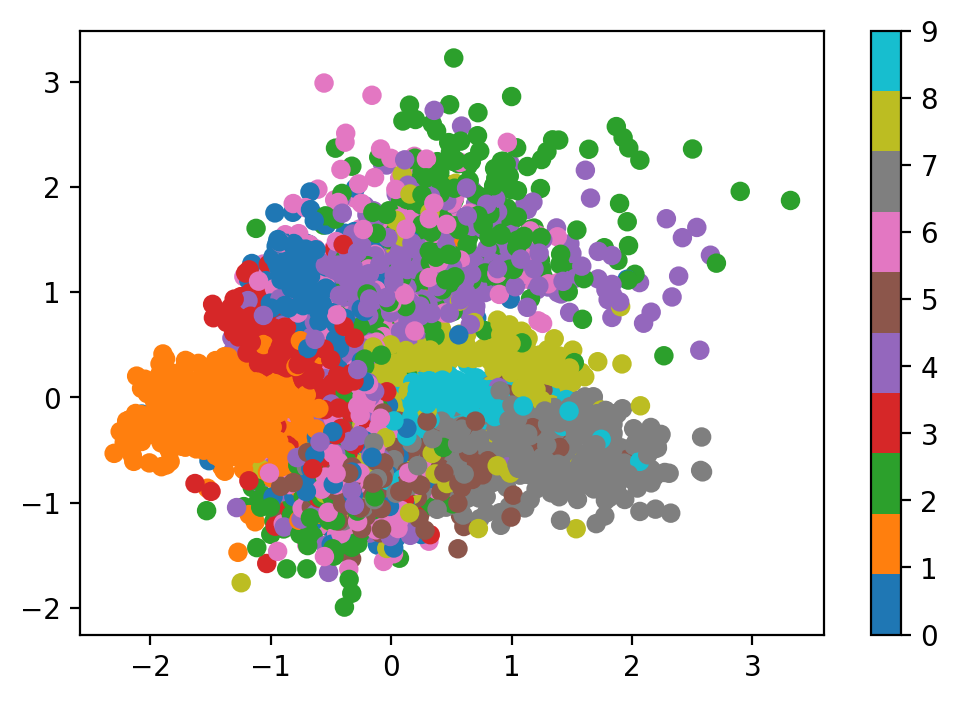

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)
plot_latent(vae, data)

-3.0 -3.0
-2.4545454545454546 -3.0
-1.9090909090909092 -3.0
-1.3636363636363638 -3.0
-0.8181818181818183 -3.0
-0.27272727272727293 -3.0
0.2727272727272725 -3.0
0.8181818181818179 -3.0
1.3636363636363633 -3.0
1.9090909090909083 -3.0
2.454545454545454 -3.0
3.0 -3.0
-3.0 -2.4545454545454546
-2.4545454545454546 -2.4545454545454546
-1.9090909090909092 -2.4545454545454546
-1.3636363636363638 -2.4545454545454546
-0.8181818181818183 -2.4545454545454546
-0.27272727272727293 -2.4545454545454546
0.2727272727272725 -2.4545454545454546
0.8181818181818179 -2.4545454545454546
1.3636363636363633 -2.4545454545454546
1.9090909090909083 -2.4545454545454546
2.454545454545454 -2.4545454545454546
3.0 -2.4545454545454546
-3.0 -1.9090909090909092
-2.4545454545454546 -1.9090909090909092
-1.9090909090909092 -1.9090909090909092
-1.3636363636363638 -1.9090909090909092
-0.8181818181818183 -1.9090909090909092
-0.27272727272727293 -1.9090909090909092
0.2727272727272725 -1.9090909090909092
0.8181818181818179 -1.90909

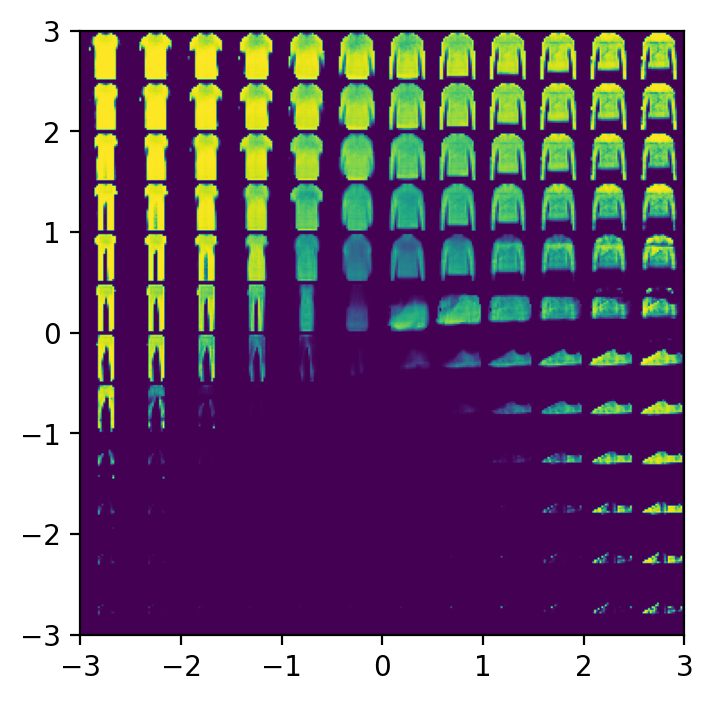

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))